<a href="https://colab.research.google.com/github/JulieMew/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
from scipy import stats
import numpy as np

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data", header=None)
df.columns = ["party",
              "handicapped-infants",
             "water-project-cost-sharing",
             "adoption-of-the-budget-resolution",
             "physician-fee-freeze",
             "el-salvador-aid",
             "religious-groups-in-schools",
             "anti-satellite-test-ban",
             "aid-to-nicaraguan-contras",
             "mx-missile",
             "immigration",
             "synfuels-corporation-cutback",
             "education-spending",
             "superfund-right-to-sue",
             "crime",
             "duty-free-exports",
             "export-administration-act-south-africa"]

df = df.replace({"?": None, "y": 1, "n": 0})

print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
df.isnull().sum()

party                                       0
handicapped-infants                        12
water-project-cost-sharing                 48
adoption-of-the-budget-resolution          11
physician-fee-freeze                       11
el-salvador-aid                            15
religious-groups-in-schools                11
anti-satellite-test-ban                    14
aid-to-nicaraguan-contras                  15
mx-missile                                 22
immigration                                 7
synfuels-corporation-cutback               21
education-spending                         31
superfund-right-to-sue                     25
crime                                      17
duty-free-exports                          28
export-administration-act-south-africa    104
dtype: int64

In [0]:
df.describe()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,423.000000,387.000000,424.000000,424.000000,420.000000,424.000000,421.000000,420.00000,413.000000,428.000000,414.000000,404.000000,410.000000,418.000000,407.000000,331.000000
mean,0.442080,0.503876,0.596698,0.417453,0.504762,0.641509,0.567696,0.57619,0.501211,0.504673,0.362319,0.423267,0.509756,0.593301,0.427518,0.812689
std,0.497222,0.500632,0.491140,0.493721,0.500574,0.480124,0.495985,0.49475,0.500605,0.500563,0.481252,0.494690,0.500516,0.491806,0.495327,0.390752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
df['handicapped-infants'].value_counts().sort_index()

0.0    236
1.0    187
Name: handicapped-infants, dtype: int64

In [0]:
democrat = df[df['party']=='democrat']

democrat.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [0]:
republican = df[df['party']=='republican']

republican.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


*These two sample means are estimates*

In [0]:
df['party'].value_counts()

democrat      267
republican    168
Name: party, dtype: int64

In [0]:
democrat['handicapped-infants'].mean()

0.6046511627906976

In [0]:
republican['handicapped-infants'].mean()

0.18787878787878787

**1. Generate and numerically represent a confidence interval**

In [0]:
republican['handicapped-infants'].std()

0.3918044370924747

In [0]:
np.nanstd(republican['handicapped-infants'].values)

0.3906153465290186

In [0]:
np.nanstd(republican['handicapped-infants'].values, ddof=1)

0.3918044370924748

In [0]:
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  # Turn my data into a numpy array for consistency
  data = np.array(data)
  # Calculate the sample mean
  x_bar = np.mean(data)
  # Sample Size
  n = len(data)
  # pass extra parameter (ddof=1) to calculate **sample** standard deviation
  s = data.std(ddof=1) 
  stderr = s / np.sqrt(n)
  # Lookup the t-statistic that corresponds to 95% area under the curve
  # for my given degrees of freedom: 49
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*stderr
  return (x_bar - margin_of_error, x_bar, x_bar + margin_of_error)

In [0]:
confidence=.95
(1 + confidence) / 2.0

0.975

In [0]:
target = republican['handicapped-infants'].dropna()

target2 = democrat['handicapped-infants'].dropna()

In [0]:
confidence_interval(target)

(0.12765166444807918, 0.18787878787878787, 0.24810591130949655)

In [0]:
confidence_interval(target2)

(0.5445926997425515, 0.6046511627906976, 0.6647096258388437)

In [0]:
small_sample_republican =  republican.sample(3)

small_sample_republican.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
84,republican,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
283,republican,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
148,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [0]:
confidence_interval(small_sample_republican['handicapped-infants'])

(0.0, 0.0, 0.0)

In [0]:
#df = df.drop('party', axis=1)

confidence_intervals = []
for col in df:
  cleaned_col = df[col].dropna()
  confidence_intervals.append(confidence_interval(cleaned_col))

confidence_intervals

[(0.39456046308364673, 0.44208037825059104, 0.48960029341753536),
 (0.45384081311663604, 0.5038759689922481, 0.5539111248678601),
 (0.5498151808536169, 0.5966981132075472, 0.6435810455614774),
 (0.37032346810896244, 0.41745283018867924, 0.46458219226839603),
 (0.4567501383795156, 0.5047619047619047, 0.5527736711442939),
 (0.595678078934313, 0.6415094339622641, 0.6873407889902152),
 (0.5201811192521687, 0.5676959619952494, 0.6152108047383301),
 (0.5287372471168422, 0.5761904761904761, 0.6236437052641101),
 (0.45278830107341983, 0.5012106537530266, 0.5496330064326335),
 (0.45711551746571655, 0.5046728971962616, 0.5522302769268067),
 (0.31582505683185436, 0.36231884057971014, 0.40881262432756593),
 (0.37488391760148726, 0.42326732673267325, 0.47165073586385925),
 (0.4611645412110688, 0.5097560975609756, 0.5583476539108825),
 (0.546017195315226, 0.5933014354066986, 0.6405856754981711),
 (0.3792525917327782, 0.4275184275184275, 0.4757842633040768),
 (0.7704384213745765, 0.8126888217522659, 

In [0]:
CI = pd.DataFrame(confidence_intervals)
CI.columns = ['lower', 'mean', 'upper']
CI['moe'] = CI['mean'] - CI['lower']
print(CI.shape)
CI.head()

(16, 4)


,lower,mean,upper,moe
0,0.394560,0.442080,0.489600,0.047520
1,0.453841,0.503876,0.553911,0.050035
2,0.549815,0.596698,0.643581,0.046883
3,0.370323,0.417453,0.464582,0.047129
4,0.456750,0.504762,0.552774,0.048012


**Graphically (with a plot) represent the confidence interval**

In [0]:
confidence_intervals[1]

(0.45384081311663604, 0.5038759689922481, 0.5539111248678601)

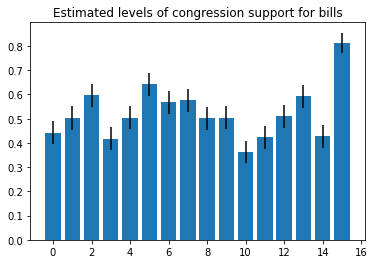

In [0]:
import matplotlib.pyplot as plt

plt.bar(x=range(0,16), height=CI['mean'], yerr=CI['moe'])
plt.title("Estimated levels of congression support for bills")
plt.show()

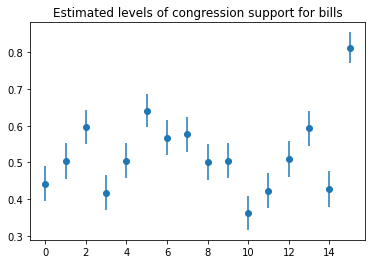

In [0]:
plt.errorbar(x=range(0,16), y=CI['mean'], yerr=CI['moe'], fmt='o')
plt.title("Estimated levels of congression support for bills")
plt.show()

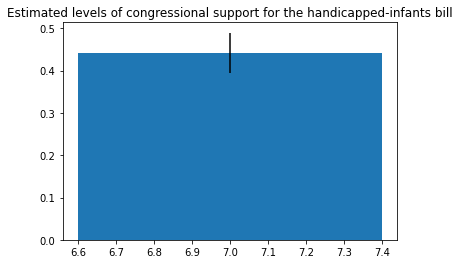

In [0]:
plt.bar(x=7, height=CI['mean'][0], yerr=CI['moe'][0])
plt.title("Estimated levels of congressional support for the handicapped-infants bill")
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


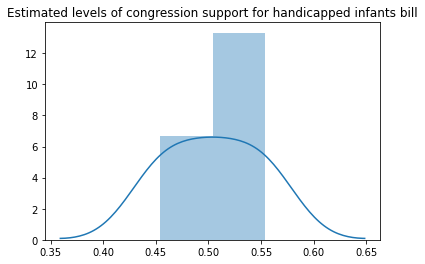

In [0]:
import seaborn as sns

sns.distplot(confidence_intervals[1])
plt.title("Estimated levels of congression support for handicapped infants bill")
plt.show()

*Chi-squared tests:
Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data
By hand using Numpy
In a single line using Scipy*

In [0]:
import pandas as pd
import scipy as scp

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?",)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
from scipy import stats

stats.chisquare([13,13,9,7,13], [40,13,40,40,40], 15)

Power_divergenceResult(statistic=87.69999999999999, pvalue=nan)

In [0]:
observed_frequencies = np.array([27, 13, 10, 15, 30, 32])
observed_frequencies

array([27, 13, 10, 15, 30, 32])

***Interpret the confidence interval - what does it tell you about the data and its distribution?***

It can be said with 95% confidence, with +/-2.5% margin for error, that democrats support the handicapped infants bill more than republicans.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

*Write a summary of your findings, mixing prose and math/code/results. Note - yes, this is by definition a political topic. It is challenging but important to keep your writing voice neutral and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).**

Estimates suggest that democrats support the handicapped infants bill 1.5 times more than republicans on average, with a confidence level of 95% and a 2.5% +/= margin of error. 

*Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.*

Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)